In [2]:
import pandas as pd
import torch
import numpy as np
import torch.nn as nn

from src.preprocessing import preprocess_df, TextEncoder
from sklearn.model_selection import train_test_split

from src.labrador import Labrador
from src.tokenizers import LabradorTokenizer
from src.dataset import LabradorDataset

from src.train import train_labrador
from src.test import test_model

In [3]:
# Dataset:
FILE = 'data/morning_lab_values.csv'
COLUMNS = ['Bic', 'Crt', 'Pot', 'Sod', 'Ure', 'Hgb', 'Plt', 'Wbc']

# Device:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('mps') if torch.cuda.is_available() else torch.device('cpu') # Apple Silicon

# Data loader:
test_size = 0.2
batch_size = 512
num_workers = 4
max_len = 8
MASKING = 0.40

# Model:
embedding_dim = 756
hidden_dim = 756
transformer_heads = 4 #12
num_blocks = 10 #12
transformer_feedforward_dim = 1024 #3072
dropout_rate = 0.3
continuous_head_activation = 'relu'

# Training:
optimizer = 'Adam'
num_epochs = 2
save_model = True
model_path = 'labrador_model_time2.pth'
categorical_loss_weight = 1.0
continuous_loss_weight = 1.0
lr = 8e-6

In [4]:
df = pd.read_csv(FILE)
df["charttime"] = pd.to_datetime(df["charttime"])
df.head()

,hadm_id,subject_id,itemid,charttime,charthour,storetime,storehour,chartday,valuenum,cnt
0,NaN,16564743,50971,2160-02-05 14:14:00,14,NaN,NaN,2160-02-05,4.9,8
1,28234655.0,18843829,51301,2131-04-05 00:07:00,0,2131-04-05 00:30:00,0.0,2131-04-05,5.7,8
2,24776258.0,19880967,51301,2174-06-15 00:00:00,0,2174-06-15 00:35:00,0.0,2174-06-15,2.2,8
3,29889929.0,17339765,51265,2143-04-26 00:00:00,0,2143-04-26 00:45:00,0.0,2143-04-26,10.0,8
4,22530452.0,19667522,51222,2188-12-14 00:00:00,0,2188-12-14 00:40:00,0.0,2188-12-14,10.1,8


In [87]:
# MinMaxScaler by default
mrl = preprocess_df(df, columns_to_scale=COLUMNS)

In [89]:
text_encoder = TextEncoder(Repetition_id=True, labs_as_num=True, return_lists=True)
mrl, grouped_mrl = text_encoder.encode_text(mrl)

In [15]:
#grouped_mrl.to_csv("data/grouped_mrl.csv")
grouped_mrl.to_csv("data/grouped_mrl_time.csv")

In [68]:
from ast import literal_eval
grouped_mrl = pd.read_csv("data/grouped_mrl_time.csv", converters={
    "lab_ids": literal_eval,
    "lab_values": literal_eval
})

In [91]:
grouped_mrl.head(3)

,hadm_id,nstr,lab_ids,lab_values
0,20000019.0,[Bic 0.16923076923076924 Crt 0.014864864864864...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.16923076923076924, 0.014864864864864867, 0...."
1,20000024.0,[Bic 0.17692307692307693 Crt 0.014864864864864...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.17692307692307693, 0.014864864864864867, 0...."
2,20000034.0,[Bic 0.16923076923076924 Crt 0.031081081081081...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.16923076923076924, 0.03108108108108108, 0.1..."


In [92]:
lab_ids = grouped_mrl.lab_ids.values
lab_values = grouped_mrl.lab_values.values
hid = grouped_mrl.hadm_id.values

hid_train, hid_test, lab_ids_train, lab_ids_test, lab_values_train, lab_values_test = train_test_split(hid, lab_ids, lab_values, test_size=test_size, random_state=42)

In [93]:
lab_ids

array([list(['Bic', 'Crt', 'Pot', 'Sod', 'Ure', 'Hgb', 'Plt', 'Wbc']),
       list(['Bic', 'Crt', 'Pot', 'Sod', 'Ure', 'Hgb', 'Plt', 'Wbc']),
       list(['Bic', 'Crt', 'Pot', 'Sod', 'Ure', 'Hgb', 'Plt', 'Wbc']),
       ...,
       list(['Bic', 'Crt', 'Pot', 'Sod', 'Ure', 'Hgb', 'Plt', 'Wbc']),
       list(['Bic', 'Crt', 'Pot', 'Sod', 'Ure', 'Hgb', 'Plt', 'Wbc']),
       list(['Bic', 'Crt', 'Pot', 'Sod', 'Ure', 'Hgb', 'Plt', 'Wbc'])],
      dtype=object)

In [72]:
lab_values_train

array([list(['0.0', '0.16923076923076924', '0.010810810810810811', '0.12109375', '0.6226415094339623', '0.04262295081967213', '0.6697247706422017', '0.044264819091608926', '0.006489809859956735', '0.0019496265246688681', '0.18461538461538463', '0.00945945945945946', '0.109375', '0.6320754716981132', '0.04262295081967213', '0.646788990825688', '0.041185527328714396', '0.005351246726630992']),
       list(['0.0', '0.19230769230769232', '0.010810810810810811', '0.12109375', '0.6698113207547169', '0.022950819672131147', '0.6055045871559632', '0.05542725173210161', '0.007514516679949903', '0.008560078959874248', '0.2076923076923077', '0.010810810810810811', '0.11328125', '0.679245283018868', '0.01639344262295082', '0.518348623853211', '0.05119322555812163', '0.004554252533302972', '0.009047485591041465', '0.2', '0.010810810810810811', '0.1015625', '0.6698113207547169', '0.01639344262295082', '0.5045871559633027', '0.0434949961508853', '0.004668108846635546', '0.009321651821073026', '0.14615

(array([2.5887e+05, 4.8380e+03, 6.8100e+02, 1.3400e+02, 3.8000e+01,
        1.5000e+01, 6.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  56. ,  739.2, 1422.4, 2105.6, 2788.8, 3472. , 4155.2, 4838.4,
        5521.6, 6204.8, 6888. ]),
 <BarContainer object of 10 artists>)

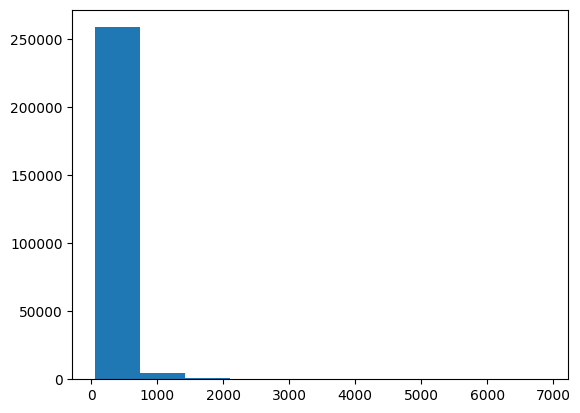

In [ ]:
import matplotlib.pyplot as plt
plt.hist([len(x) for x in lab_ids])

In [20]:
np.median([len(x) for x in lab_ids])

24.0

In [95]:
tokenizer = LabradorTokenizer()
# Get unique lab ids:
unique_ids = set(np.concatenate(lab_ids_train))
# train the tokenizer:
tokenizer.train(unique_ids)
tokenizer.save_pretrained('labrador_tokenizer/')

In [42]:
import json
d = json.load(open("labrador_tokenizer/tokenizer_config_time.json"))
tokenizer = LabradorTokenizer()
tokenizer.mask_token = d["mask_token"]
tokenizer.null_token = d["null_token"]
tokenizer.pad_token = d["pad_token"]
tokenizer.special_tokens = d["special_tokens"]
tokenizer.vocab = d["vocab"]
tokenizer.inverse_vocab = {v: k for k, v in tokenizer.vocab.items()}

In [96]:
tokenizer.tokenize_batch(lab_ids_train[:1], lab_values_train[:1], max_length=64)

{'input_ids': array([[ 1,  7,  5,  2,  6,  3,  4,  0, 10, 10, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]]),
 'continuous': array([[1.69230769e-01, 1.08108108e-02, 1.21093750e-01, 6.22641509e-01,
         4.26229508e-02, 6.69724771e-01, 4.42648191e-02, 6.48980986e-03,
         1.00000000e+01, 1.00000000e+01, 1.00000000e+01, 1.00000000e+01,
         1.00000000e+01, 1.00000000e+01, 1.00000000e+01, 1.00000000e+01,
         1.00000000e+01, 1.00000000e+01, 1.00000000e+01, 1.00000000e+01,
         1.00000000e+01, 1.00000000e+01, 1.00000000e+01, 1.00000000e+01,
         1.00000000e+01, 1.00000000e+01, 1.00000000e+01, 1.00000000e+01,
         1.00000000e+01, 1.00000000e+01, 1.00000000e+01, 1.00000000e+01,
         1.00000000e+01, 1.00000000e+01, 1.00000000e+01, 1.00000000e+01,
         1.00000000e+

In [97]:
dataset_train = LabradorDataset(continuous=lab_values_train, categorical=lab_ids_train, tokenizer=tokenizer, max_len=8, masking_prob=MASKING)
dataset_test = LabradorDataset(continuous=lab_values_test, categorical=lab_ids_test, tokenizer=tokenizer, max_len=8, masking_prob=MASKING)

# Dataloader:
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=num_workers)

{'[MASK]': 8, '[NULL]': 9, '[PAD]': 10, 'Wbc': 0, 'Bic': 1, 'Sod': 2, 'Hgb': 3, 'Plt': 4, 'Pot': 5, 'Ure': 6, 'Crt': 7}
{'[MASK]': 8, '[NULL]': 9, '[PAD]': 10, 'Wbc': 0, 'Bic': 1, 'Sod': 2, 'Hgb': 3, 'Plt': 4, 'Pot': 5, 'Ure': 6, 'Crt': 7}


In [98]:
mask_token = tokenizer.mask_token #-1
null_token = tokenizer.null_token #-2
pad_token = tokenizer.pad_token #-3
vocab_size = tokenizer.vocab_size()

In [99]:
model = Labrador(mask_token=mask_token, pad_token=pad_token, null_token=null_token, vocab_size=vocab_size, embedding_dim=embedding_dim, transformer_heads=transformer_heads, num_blocks=num_blocks, transformer_feedforward_dim=transformer_feedforward_dim, include_head=True, continuous_head_activation=continuous_head_activation, dropout_rate=dropout_rate)
model

Labrador(
  (categorical_embedding_layer): Embedding(14, 756)
  (continuous_embedding_layer): ContinuousEmbedding(
    (special_token_embeddings): Embedding(3, 756)
    (dense1): Linear(in_features=1, out_features=756, bias=True)
    (dense2): Linear(in_features=756, out_features=756, bias=True)
    (layernorm): LayerNorm((756,), eps=1e-05, elementwise_affine=True)
  )
  (projection_layer): Linear(in_features=1512, out_features=756, bias=True)
  (blocks): ModuleList(
    (0-9): 10 x TransformerBlock(
      (att): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=756, out_features=756, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=756, out_features=1024, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1024, out_features=756, bias=True)
      )
      (layernorm1): LayerNorm((756,), eps=1e-05, elementwise_affine=True)
      (layernorm2): LayerNorm((756,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dr

In [46]:
model.load_state_dict(torch.load("labrador_model_time.pth"))

<All keys matched successfully>

In [100]:
# Loss functions
categorical_loss_fn = nn.CrossEntropyLoss()
continuous_loss_fn = nn.MSELoss()

  0%|          | 0/485 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 122/122 [00:05<00:00, 21.40it/s]


Epoch 1/15, Training Loss: 2.2058895978730977, Validation Loss: 1.9726178020727438


100%|██████████| 122/122 [00:05<00:00, 21.39it/s]


Epoch 2/15, Training Loss: 1.9533544260201996, Validation Loss: 1.9291614381993403


100%|██████████| 122/122 [00:05<00:00, 21.48it/s]


Epoch 3/15, Training Loss: 1.9323854003984904, Validation Loss: 1.9322861218061604


100%|██████████| 122/122 [00:05<00:00, 21.31it/s]


Epoch 4/15, Training Loss: 1.9261571146778225, Validation Loss: 1.9226825305672943


100%|██████████| 122/122 [00:05<00:00, 21.21it/s]


Epoch 5/15, Training Loss: 1.921068473206353, Validation Loss: 1.9112872754941221


 99%|█████████▉| 121/122 [00:05<00:00, 30.37it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 122/122 [00:05<00:00, 20.87it/s]


Epoch 6/15, Training Loss: 1.9184344291687012, Validation Loss: 1.9139834114762604


100%|██████████| 122/122 [00:05<00:00, 20.78it/s]


Epoch 7/15, Training Loss: 1.9157345366232175, Validation Loss: 1.9142433229039928


100%|██████████| 122/122 [00:05<00:00, 21.15it/s]


Epoch 8/15, Training Loss: 1.9148942229674035, Validation Loss: 1.9129734615810583


100%|██████████| 122/122 [00:05<00:00, 21.13it/s]


Epoch 9/15, Training Loss: 1.9143150786763614, Validation Loss: 1.9145236640680032


100%|██████████| 122/122 [00:05<00:00, 20.81it/s]


Epoch 10/15, Training Loss: 1.912327099829605, Validation Loss: 1.9099384907816277


100%|██████████| 122/122 [00:05<00:00, 21.24it/s]


Epoch 11/15, Training Loss: 1.9127572037510037, Validation Loss: 1.9337796480929266


100%|██████████| 122/122 [00:05<00:00, 21.12it/s]


Epoch 12/15, Training Loss: 1.9165230173425576, Validation Loss: 1.912376621707541


100%|██████████| 122/122 [00:05<00:00, 21.11it/s]


Epoch 13/15, Training Loss: 1.9139174599008462, Validation Loss: 1.9180587119743473


100%|██████████| 122/122 [00:05<00:00, 21.30it/s]


Epoch 14/15, Training Loss: 1.910006101844237, Validation Loss: 1.9149970685849425


100%|██████████| 122/122 [00:05<00:00, 21.21it/s]


Epoch 15/15, Training Loss: 1.9110400435850792, Validation Loss: 1.9082000763689886


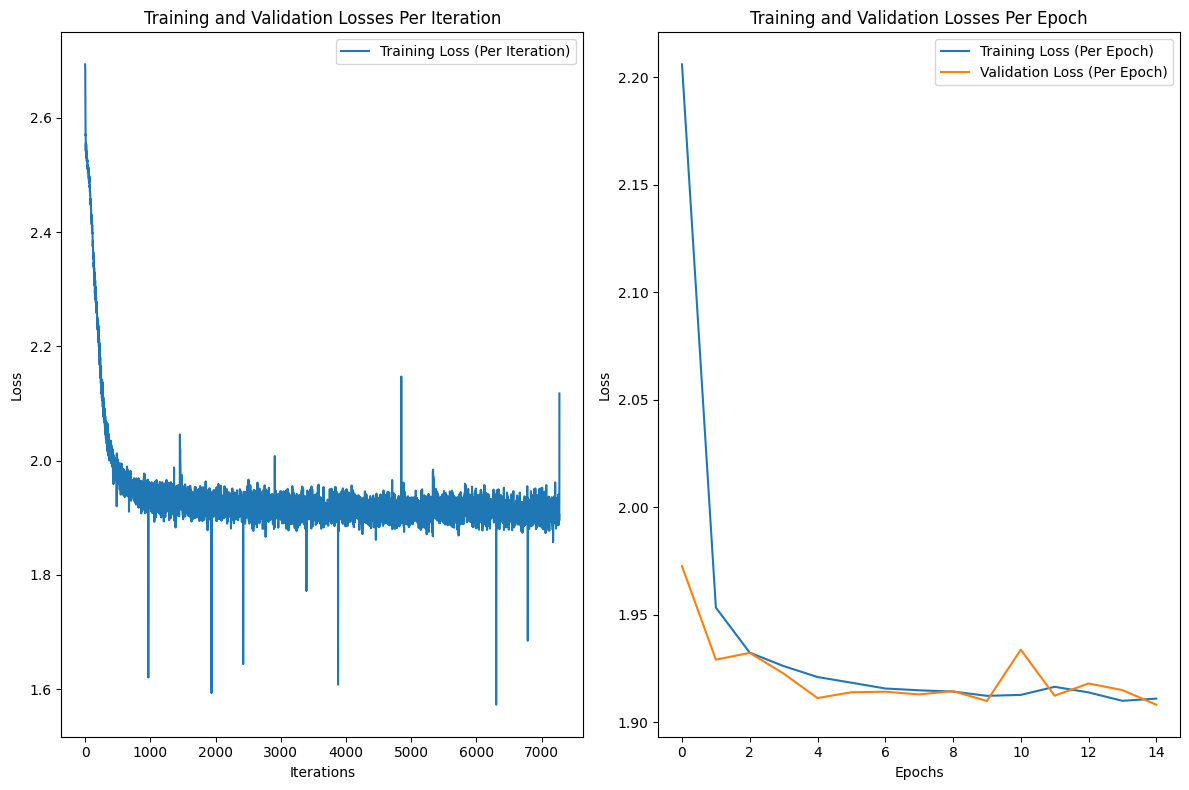

In [101]:
# Train and validate the model
trained_model = train_labrador(model, train_loader, test_loader, categorical_loss_fn, continuous_loss_fn, optimizer=optimizer, num_epochs=15, device=device, save_model=save_model, model_path=model_path, categorical_loss_weight=categorical_loss_weight, continuous_loss_weight=continuous_loss_weight, lr=lr)

In [102]:
dataset_test = LabradorDataset(continuous=lab_values_test, categorical=lab_ids_test, tokenizer=tokenizer, max_len=8, masking_prob=0)
# Dataloader:
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

{'[MASK]': 8, '[NULL]': 9, '[PAD]': 10, 'Wbc': 0, 'Bic': 1, 'Sod': 2, 'Hgb': 3, 'Plt': 4, 'Pot': 5, 'Ure': 6, 'Crt': 7}


In [ ]:
metrics = test_model(model, test_loader, device, COLUMNS)

In [49]:
metrics

{'Bic': {'rmse': [0.03037921029564815],
  'mape': [0.14531462606901052],
  'r2': [-0.019617405139207955]},
 'Crt': {'rmse': [0.021070957063985433],
  'mape': [0.8704646275272782],
  'r2': [-0.07834770000758118]},
 'Pot': {'rmse': [0.02298423125677432],
  'mape': [0.13635105503982498],
  'r2': [0.08565181042415926]},
 'Sod': {'rmse': [0.03874158325880314],
  'mape': [0.04704328706149929],
  'r2': [-0.022956319097880984]},
 'Ure': {'rmse': [0.04031676751461197],
  'mape': [0.3791407531124362],
  'r2': [0.5078218869370426]},
 'Hgb': {'rmse': [0.10098323922337832],
  'mape': [0.1606179488184385],
  'r2': [-0.08349508278910589]},
 'Plt': {'rmse': [0.042634675843707434],
  'mape': [0.7243494488645746],
  'r2': [-0.01513871320106519]},
 'Wbc': {'rmse': [0.013419379341286512],
  'mape': [1.0],
  'r2': [-1.478061596588844]}}

In [105]:
with open("metrics_orig.csv", "w") as f:
    f.write(f"Lab,{','.join(metrics['Bic'].keys())}\n")
    for k, v in metrics.items():
        f.write(f"{k},{v['rmse'][0]},{v['mape'][0]},{v['r2'][0]}\n")

In [14]:
# DOWNSTREAM TASK

dataset_test = LabradorDataset(continuous=lab_values_test, categorical=lab_ids_test, tokenizer=tokenizer, max_len=36, masking_prob=0.4)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

{'[MASK]': 9, '[NULL]': 10, '[PAD]': 11, 'Sod': 0, 'Time': 1, 'Wbc': 2, 'Pot': 3, 'Plt': 4, 'Crt': 5, 'Ure': 6, 'Hgb': 7, 'Bic': 8}


In [15]:
df = grouped_mrl.set_index("hadm_id").loc[hid_test]

In [20]:
from tqdm import tqdm

idx = 0
with torch.no_grad():
    for batch in tqdm(test_loader, leave=True):
        input_ids = batch['input_ids'].to(device)
        continuous = batch['continuous'].to(device)
        attn_mask = batch['attention_mask'].to(device)
        labels_continuous = batch['labels_continuous'].to(device)

        # If no 0s in attention mask, set it to None
        attn_mask_zero = (attn_mask == 0).any().item()
        if attn_mask_zero == 0:
            # print('No 0s in attention mask')
            attn_mask = None

        outputs = model(input_ids, continuous, attn_mask=attn_mask)
        for k, o in enumerate(outputs['continuous_output']):
            l = df.iloc[idx].lab_values.copy()
            for i, x in enumerate(continuous[k]):
                if x == 9:
                    l[i] = o.cpu().numpy()[i].item()
            df.iat[idx, -1] = [str(x) for x in l]
            idx += 1

  0%|          | 0/122 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 122/122 [02:01<00:00,  1.01it/s]


In [24]:
def format_test(df):
    d = []
    for i, row in df.iterrows():
        if len(row.lab_ids) < 36:
            continue
        r = {"hadm_id": i}
        for j in range(4):
            for k in range(1, 9):
                ind = j * 9 + k
                r[row.lab_ids[ind] + str(j)] = row.lab_values[ind]
        d.append(r)
    return pd.DataFrame(d)

In [27]:
df = format_test(df)
df.to_csv("data/test_impute.csv")

orig = format_test(grouped_mrl.set_index("hadm_id").loc[hid_test])
orig.to_csv("data/test_orig.csv")

In [69]:
out.head()

,hadm_id,Bic0,Crt0,Pot0,Sod0,Ure0,Hgb0,Plt0,Wbc0,Bic1,...,Plt2,Wbc2,Bic3,Crt3,Pot3,Sod3,Ure3,Hgb3,Plt3,Wbc3
0,28801378.0,0.19230769230769232,0.005405405405405406,0.171875,0.6037735849056605,0.14328762888908386,0.46905234456062317,0.14328762888908386,0.009222361379938518,0.19436319172382355,...,0.11200923787528867,0.00899464875327337,0.23076923076923078,0.0,0.116545669734478,0.5754716981132075,0.01639344262295082,0.4449541284403669,0.096612779060816,0.0
1,24010811.0,0.16153846153846155,0.043243243243243246,0.125,0.2075914442539215,0.3377049180327869,0.41463738679885864,0.0703812912106514,0.0,0.2075914442539215,...,0.2075914442539215,0.011613343959922577,0.18461538461538463,0.03513513513513514,0.13020643591880798,0.6189209222793579,0.2075914442539215,0.40366972477064217,0.06043110084680523,0.006945235113287032
2,25171589.0,0.22056101262569427,0.02837837837837838,0.1875,0.5754716981132075,0.22056101262569427,0.40366972477064217,0.04340183734893799,0.006717522486621884,0.16808918118476868,...,0.06235565819861432,0.22056101262569427,0.16808918118476868,0.04624431952834129,0.1171875,0.6377491354942322,0.04262295081967213,0.22056101262569427,0.06581986143187066,0.007059091426619607
3,25142314.0,0.16923076923076924,0.0,0.14453125,0.5660377358490567,0.07971347123384476,0.38532110091743116,0.1193225558121632,0.004326539906637823,0.17069444060325623,...,0.0961233526468277,0.007286804053284756,0.17692307692307693,0.0039957850240170956,0.14453125,0.6033903956413269,0.07868852459016393,0.3907417058944702,0.1173979984603541,0.00421268359330525
4,22089864.0,0.06259986758232117,0.0,0.11554412543773651,0.5283018867924529,0.03945424035191536,0.48165137614678893,0.046189376443418015,0.02459296367983605,0.14615384615384616,...,0.04503464203233256,0.06259986758232117,0.06259986758232117,0.012162162162162163,0.06259986758232117,0.6320754716981132,0.03945424035191536,0.34862385321100914,0.05350269438029253,0.0
